In [71]:
# Run this command to upload the kaggle token file to the colab
from google.colab import files
files.upload()  

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"victorolatunji","key":"254c62dc3a9b89aaedacc9d4517bb74e"}'}

In [72]:
# Now lets install kaggle API 
!pip install -q kaggle

In [73]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [74]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset 

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [75]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2179          6  0.1764706        


In [76]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 688M/691M [00:06<00:00, 53.4MB/s]
100% 691M/691M [00:06<00:00, 109MB/s] 
/content


In [77]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv 

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [78]:
# Important library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
import keras.utils as image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam,SGD

In [79]:
# Read the labels.csv file and checking shape and records
df = pd.read_csv("dog_dataset/labels.csv")
print(df.shape)
df.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# New Section

In [80]:
# Visualize the number of each breeds
breeds_all = df["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head() 

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [81]:
# Selecting first 4 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog',] 
# "entlebucher","afghan_hound" 
labels = df[(df['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index() 
labels.head(10) 

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog
5,161,03dc61595ad9dbf49e3998cf586ca8cb,scottish_deerhound
6,164,03dfefdb2939388f7ca9578cb7c4a2b9,maltese_dog
7,165,03e1d2ee5fd90aef036c90a9e7f81177,bernese_mountain_dog
8,219,04fb4d719e9fe2b6ffe32d9ae7be8a22,bernese_mountain_dog
9,223,05134ea3341a1f4f460168e68ec5765d,bernese_mountain_dog


In [82]:
labels.shape

(357, 3)

In [83]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0) 
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size)) 

100%|██████████| 357/357 [00:01<00:00, 285.38it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [84]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu',kernel_regularizer = 'l2', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4)) 


model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.6))

model.add(Conv2D(filters = 32, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2))) 
model.add(Dropout(0.2))

model.add(Conv2D(filters = 16, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2))) 
model.add(Dropout(0.2))

model.add(Conv2D(filters = 8, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

# OUTTER LAYER

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax")) 

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 111, 111, 128)     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 107, 107, 64)      204864    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 53, 53, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 53, 53, 64)       

In [85]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2) 

In [94]:
len(X_train)

256

In [86]:
# Training the model
%%time 
epochs = 150
batch_size = 64
verbose = 0 

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val)) 

Epoch 1/150
4/4 [==============================] - 2s 416ms/step - loss: 4.5066 - accuracy: 0.3867 - val_loss: 4.4930 - val_accuracy: 0.3692
Epoch 2/150
4/4 [==============================] - 1s 308ms/step - loss: 4.4599 - accuracy: 0.3750 - val_loss: 4.4599 - val_accuracy: 0.3692
Epoch 3/150
4/4 [==============================] - 1s 312ms/step - loss: 4.4302 - accuracy: 0.4141 - val_loss: 4.4283 - val_accuracy: 0.3538
Epoch 4/150
4/4 [==============================] - 1s 307ms/step - loss: 4.3976 - accuracy: 0.4062 - val_loss: 4.3960 - val_accuracy: 0.3231
Epoch 5/150
4/4 [==============================] - 1s 311ms/step - loss: 4.3627 - accuracy: 0.4180 - val_loss: 4.3640 - val_accuracy: 0.3538
Epoch 6/150
4/4 [==============================] - 1s 310ms/step - loss: 4.3237 - accuracy: 0.4258 - val_loss: 4.3324 - val_accuracy: 0.3846
Epoch 7/150
4/4 [==============================] - 1s 305ms/step - loss: 4.3013 - accuracy: 0.3594 - val_loss: 4.3010 - val_accuracy: 0.4154
Epoch 8/150
4

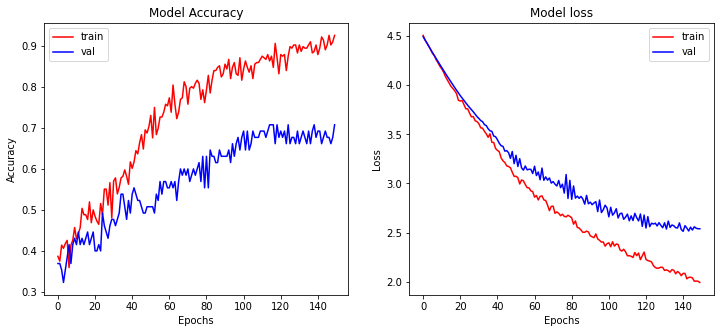

In [93]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1) 
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

# Plot the training history

plt.subplot(1,2,2) 
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show() 

In [98]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 22ms/step - loss: 2.2413 - accuracy: 0.8611
Accuracy over the test set: 
  86.11 %


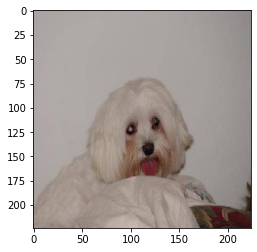

Original:  maltese_dog
Predicted :  maltese_dog


In [110]:
# Plotting image to compare
plt.imshow(X_test[0,:,:,:])
plt.show() 

# Finding max value from predition list and comaparing original value vs predicted
print("Original: ",labels['breed'][np.argmax(Y_test[0])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[0])])

In [90]:
model.save("dog_model.h5")  